In [1]:
import os, time, math, glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm

In [2]:
# Constants definition
IMAGE_SIZE = (128, 128)
N_CHANNELS = 3
BATCH_SIZE = 32
NUM_EXAMPLES = 1
NORM_FACTOR = 255. / 2
EPOCHS = 200
LATENT_DIMS = 100

In [3]:
# Load flowers dataset
dataset_path = "flowers"

train_ds = keras.utils.image_dataset_from_directory(
    directory=dataset_path, 
    image_size=IMAGE_SIZE,
    seed=101
)

train_ds

Found 4178 files belonging to 5 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
NUM_CLASSES = train_ds.class_names
NUM_CLASSES

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [5]:
# Filter only rose images
small_ds = train_ds.unbatch().filter(lambda x, y: tf.equal(y, 2) or tf.equal(y, 3)).batch(BATCH_SIZE)
small_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

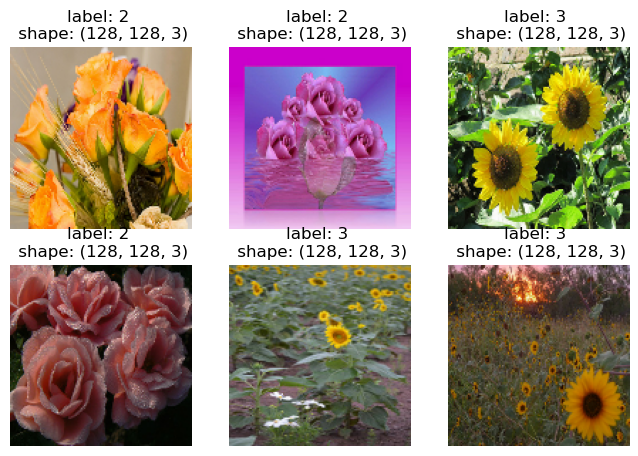

In [6]:
# Visualize sample images
plt.figure(figsize=(8, 8), dpi=100)
for (x, y) in small_ds.take(1):
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[i].numpy().astype('uint8'))
        plt.title(f'label: {y[i].numpy()} \n shape: {x[i].numpy().shape}')
        plt.axis('off')

In [7]:
# Preprocess images
def preprocess(data, label):
    data = tf.image.resize(data, IMAGE_SIZE)
    return ((data - NORM_FACTOR) / NORM_FACTOR, label)

def deprocess(data):
    return data * NORM_FACTOR + NORM_FACTOR

small_ds = small_ds.shuffle(buffer_size=4000).map(preprocess).prefetch(1).cache()
small_ds

<CacheDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

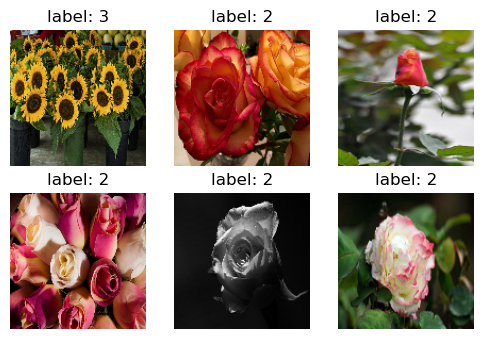

In [8]:
# Visualize preprocessed images
plt.figure(figsize=(6, 6), dpi=100)

for (x, y) in small_ds.take(1):
    for i in range(0, 6):
        img = x[i]
        label = y[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(deprocess(img.numpy()).astype(np.uint8))
        plt.title(f'label: {label}')
        plt.axis('off')

In [9]:
# GAN model
class GAN():
    def __init__(self, latent_dims, input_shape, batch_size, training_size=None):
        self.latent_dims = latent_dims
        self.image_shape = input_shape
        self.batch_size = batch_size
        self.training_size = training_size
        self.checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        
        self.cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
        
        self.generator_optimizer = keras.optimizers.Adam(3e-4)
        self.discriminator_optimizer = keras.optimizers.Adam(3e-4)
        
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
    
    def build_generator(self):
        model = keras.Sequential([
            keras.layers.Dense(8*8*1024, input_shape=(self.latent_dims, )),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Reshape((8, 8, 1024)),
            keras.layers.Conv2DTranspose(512, (4, 4), strides=2, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2DTranspose(64, (4, 4), strides=1, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')
        ])
        return model
    
    def build_discriminator(self):
        model = keras.Sequential([
            keras.layers.Conv2D(64, (4, 4), strides=1, padding='same', input_shape=self.image_shape),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.5),
            keras.layers.Conv2D(128, (4, 4), strides=2, padding='same'),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.3),
            keras.layers.Conv2D(256, (4, 4), strides=2, padding='same'),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.3),
            keras.layers.Conv2D(512, (4, 4), strides=2, padding='same'),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.3),
            keras.layers.Flatten(),
            keras.layers.Dense(1)
        ])
        return model
    
    def generator_loss(self, fakes):
        return self.cross_entropy(tf.ones_like(fakes), fakes)
    
    def discriminator_loss(self, reals, fakes):
        real_loss = self.cross_entropy(tf.ones_like(reals), reals)
        fake_loss = self.cross_entropy(tf.zeros_like(fakes), fakes)
        return real_loss + fake_loss
    
    @tf.function
    def train_step(self, images):
        noise = tf.random.normal(shape=(self.batch_size, self.latent_dims))
        
        with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
            generated_images = self.generator(noise, training=True)
            
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            
            generator_loss = self.generator_loss(fakes=fake_output)
            discriminator_loss = self.discriminator_loss(reals=real_output, fakes=fake_output)
            
        generator_gradients = generator_tape.gradient(generator_loss, self.generator.trainable_variables)
        discriminator_gradients = discriminator_tape.gradient(discriminator_loss, self.discriminator.trainable_variables)
        
        self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))
    
    def get_checkpoint_callback(self):
        checkpoint = tf.train.Checkpoint(
            generator_optimizer=self.generator_optimizer,
            discriminator_optimizer=self.discriminator_optimizer,
            generator=self.generator,
            discriminator=self.discriminator
        )
        return checkpoint
    
    def train(self, dataset, epochs, seed, load_from_checkpoint=False):
        checkpointer = self.get_checkpoint_callback()
        if load_from_checkpoint:
            try:
                checkpointer.restore(tf.train.latest_checkpoint(self.checkpoint_dir))
            except:
                print('Could not load from checkpoint')
        start_training = time.time()
        for epoch in range(1, epochs + 1):
            start = time.time()
            progress = tqdm(enumerate(dataset))
            for batch_idx, (image_batch, _) in progress:
                self.train_step(image_batch)
                self.generate_and_save(epoch, seed)
                if self.training_size is not None:
                    progress.set_description(f'Batch: {batch_idx+1}/{math.ceil(self.training_size/self.batch_size)}')
                else:
                    progress.set_description(f'Batch: {batch_idx+1}')
            end = time.time()
            print(f'Epoch: {epoch}/{epochs} | Time: {math.ceil(end - start)} seconds')
            if (epoch + 1) % 15 == 0:
                print('Checkpointing')
                checkpointer.save(file_prefix=self.checkpoint_prefix)
        end_training = time.time()  
        print(f'Training duration: {math.ceil(end_training - start_training)} seconds')
        
        self.generate_and_save(epochs, seed)
        return True
    
    def generate_and_save(self, epoch, test):
        generated_images = self.generator(test, training=False)
        plt.figure(figsize=(4, 4), dpi=200)
        for i in range(generated_images.shape[0]):
            plt.imshow(deprocess(generated_images[i].numpy()).astype(np.uint8))
            plt.axis('off')
        plt.savefig(f'generated-flowers-images/image_at_epoch__{epoch}.png')
        plt.close()

In [10]:
# Create a directory for generated images
if not os.path.isdir('generated-flowers-images'):
    os.mkdir('generated-flowers-images')

In [11]:
# Random starting seed
seed = tf.random.normal([NUM_EXAMPLES, LATENT_DIMS])

In [12]:
# Initialize a GAN model
gan = GAN(
    latent_dims=LATENT_DIMS, 
    input_shape=IMAGE_SIZE + (N_CHANNELS, ), 
    batch_size=BATCH_SIZE
)

In [13]:
gan.generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6619136   
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 512)      8389120   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 512)      2

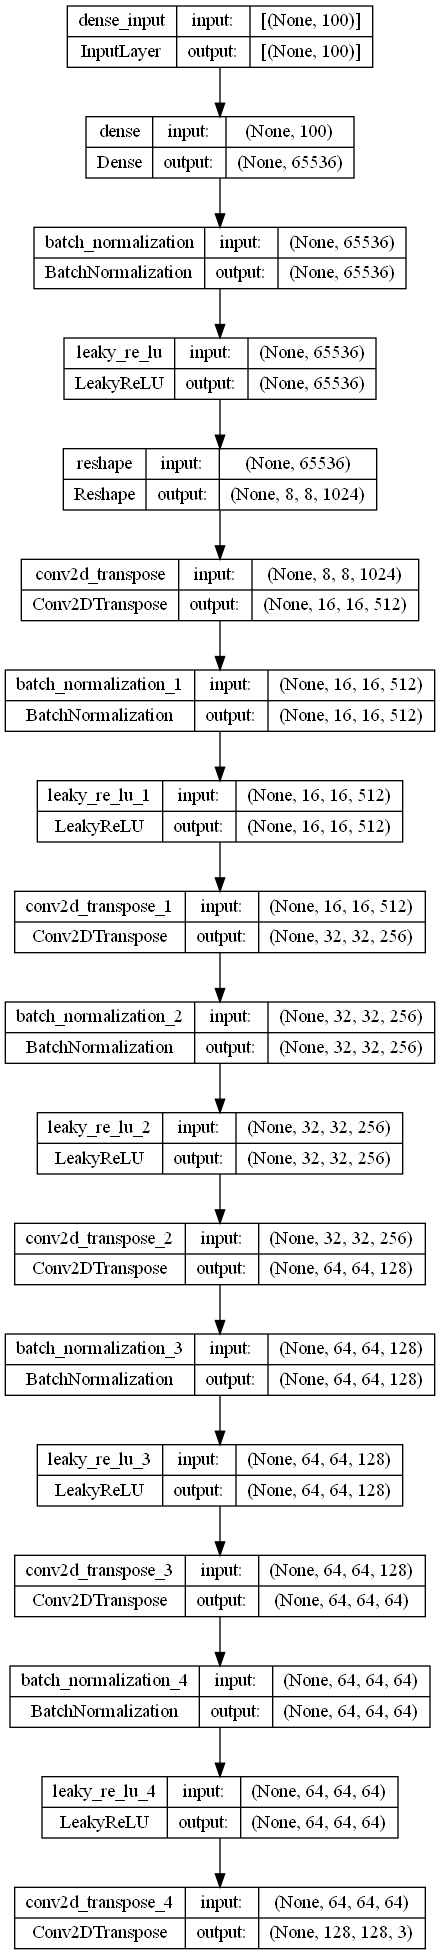

In [14]:
keras.utils.plot_model(model=gan.generator, to_file='flower-gan-generator.png', show_shapes=True)

In [15]:
gan.discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)      

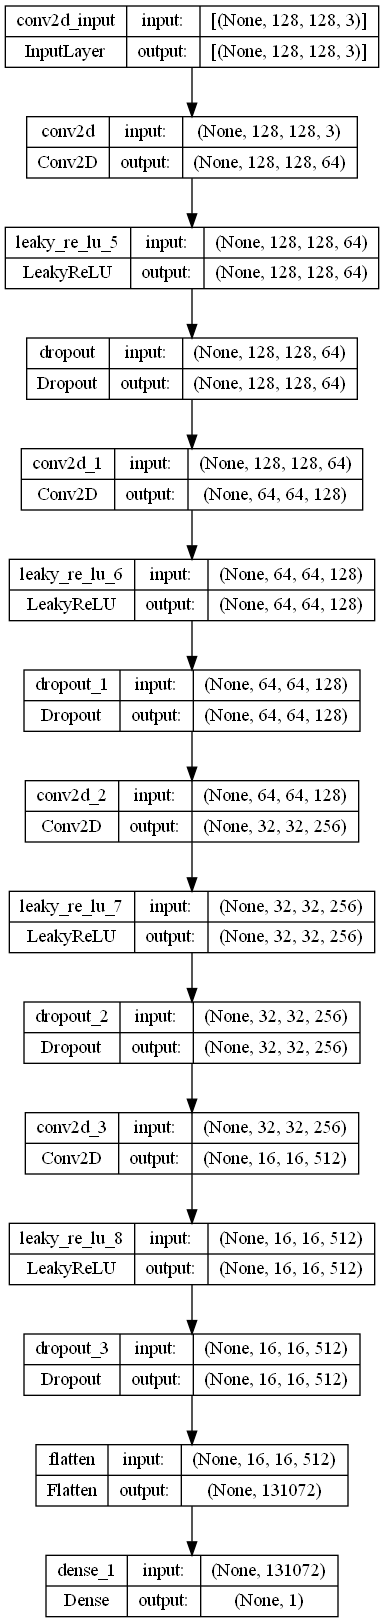

In [16]:
keras.utils.plot_model(model=gan.discriminator, to_file='flower-gan-discriminator.png', show_shapes=True)

In [17]:
# Train gan
gan.train(dataset=small_ds, epochs=EPOCHS, seed=seed)

0it [00:00, ?it/s]

Epoch: 1/200 | Time: 26 seconds


0it [00:00, ?it/s]

Epoch: 2/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 3/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 4/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 5/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 6/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 7/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 8/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 9/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 10/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 11/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 12/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 13/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 14/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 15/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 16/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 17/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 18/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 19/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 20/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 21/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 22/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 23/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 24/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 25/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 26/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 27/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 28/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 29/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 30/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 31/200 | Time: 16 seconds


0it [00:00, ?it/s]

Epoch: 32/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 33/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 34/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 35/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 36/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 37/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 38/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 39/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 40/200 | Time: 16 seconds


0it [00:00, ?it/s]

Epoch: 41/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 42/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 43/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 44/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 45/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 46/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 47/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 48/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 49/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 50/200 | Time: 16 seconds


0it [00:00, ?it/s]

Epoch: 51/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 52/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 53/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 54/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 55/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 56/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 57/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 58/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 59/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 60/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 61/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 62/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 63/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 64/200 | Time: 17 seconds


0it [00:00, ?it/s]

Epoch: 65/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 66/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 67/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 68/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 69/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 70/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 71/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 72/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 73/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 74/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 75/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 76/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 77/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 78/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 79/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 80/200 | Time: 17 seconds


0it [00:00, ?it/s]

Epoch: 81/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 82/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 83/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 84/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 85/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 86/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 87/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 88/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 89/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 90/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 91/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 92/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 93/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 94/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 95/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 96/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 97/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 98/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 99/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 100/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 101/200 | Time: 18 seconds


0it [00:00, ?it/s]

Epoch: 102/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 103/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 104/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 105/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 106/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 107/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 108/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 109/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 110/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 111/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 112/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 113/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 114/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 115/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 116/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 117/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 118/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 119/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 120/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 121/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 122/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 123/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 124/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 125/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 126/200 | Time: 18 seconds


0it [00:00, ?it/s]

Epoch: 127/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 128/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 129/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 130/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 131/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 132/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 133/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 134/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 135/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 136/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 137/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 138/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 139/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 140/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 141/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 142/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 143/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 144/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 145/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 146/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 147/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 148/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 149/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 150/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 151/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 152/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 153/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 154/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 155/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 156/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 157/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 158/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 159/200 | Time: 20 seconds


0it [00:00, ?it/s]

Epoch: 160/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 161/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 162/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 163/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 164/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 165/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 166/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 167/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 168/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 169/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 170/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 171/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 172/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 173/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 174/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 175/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 176/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 177/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 178/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 179/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 180/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 181/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 182/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 183/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 184/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 185/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 186/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 187/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 188/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 189/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 190/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 191/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 192/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 193/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 194/200 | Time: 15 seconds
Checkpointing


0it [00:00, ?it/s]

Epoch: 195/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 196/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 197/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 198/200 | Time: 15 seconds


0it [00:00, ?it/s]

Epoch: 199/200 | Time: 21 seconds


0it [00:00, ?it/s]

Epoch: 200/200 | Time: 15 seconds
Training duration: 2878 seconds


True

In [18]:
model_path = 'models'

gan.generator.save(os.path.join(model_path, 'flower_gan_generator'))
gan.discriminator.save(os.path.join(model_path, 'flower_gan_discriminator'))

INFO:tensorflow:Assets written to: models\flower_gan_generator\assets


INFO:tensorflow:Assets written to: models\flower_gan_generator\assets


INFO:tensorflow:Assets written to: models\flower_gan_discriminator\assets


INFO:tensorflow:Assets written to: models\flower_gan_discriminator\assets


1/1 [==============================] - 0s 24ms/step


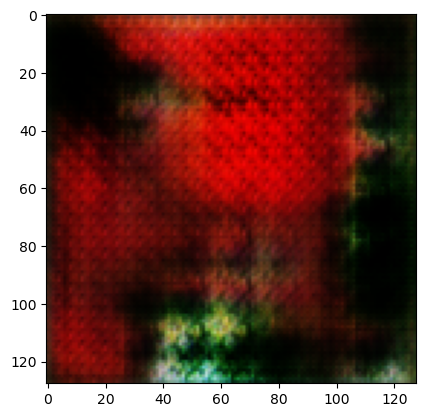

In [31]:
seed = tf.random.normal([NUM_EXAMPLES, LATENT_DIMS])

out = gan.generator.predict(seed)

plt.imshow(deprocess(out[0]).astype('uint8'))